# Air Track

### Date: 13/05/19 - 14/05/19
### Group Members: Aayushi Verma, Diana Kommedal, Alex Goodenbour

## Introduction

## Method

## Analysis

### Setup and helper function definition

In [207]:
# Setup and helper function definition

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
from scipy.optimize import minimize
from scipy.stats import chisquare
from decimal import Decimal

def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

def pairs_amps(lst):
    if (len(lst)%2)!=0:
        raise Exception("Odd list")
    amps = []
    for i, val in enumerate(lst):
        if (i%2)==0:
            amps.append((lst[i+1]-lst[i])/2)
    return amps


def sinusoid(params, t):
    A, w, phase = params
    return A*np.sin(w*t+phase)


def chi2(params, data):
    """Function to compute chi-squared"""

    t = data[:,0]
    y = data[:,1]
    #sigma = data [:,2]
    
    expected = sinusoid(params, t)
    return chisquare(y, expected)[0]

    # Add some lines to compute and return chi^2.
    # Make use of your mlens function.

def calc_sin(guesses, pnts):
    result = minimize(chi2,guesses, method='BFGS',args=(pnts))
    param_unc = np.sqrt(2*np.diag(result.hess_inv))
    newparams = result.x
    #print(newparams)
    return newparams, param_unc[1]


in_to_cm = lambda x: 2.54*x
w_to_f = lambda w: w/(2*np.pi)

data = pds.read_csv("air_track.csv")

### Measuring the Spring Constant

In [208]:
extensions = (np.array(data.initial - data.final)*1e-2)[:10]

m = 19.99e-3

m_car = 0.184

cardist = 10e-2

g = 9.81
del_x = np.mean(extensions)
del_x_unc = np.std(extensions)/np.sqrt(len(extensions))

s = (m*g)/del_x
# Propagation of uncertainties
s_unc = s*(del_x_unc/del_x)

print("Calculated Spring Constant: ", round(Decimal(s),2),"±", round_to_1(s_unc),  "Nm^-1")

Calculated Spring Constant:  4.60 ± 0.07 Nm^-1


### Calculating the Theoretical Mode Frequencies

In [209]:
w = lambda m, K, M: 2*np.sqrt(K/M)*np.sin((np.pi*m)/20)

print("Theoretical Mode Frequencies:")
for i in range(9):
    print("f", i+1, ":", round(Decimal(w_to_f(w(i+1, s, m_car))),4), "Hz")

Theoretical Mode Frequencies:
f 1 : 0.2491 Hz
f 2 : 0.4920 Hz
f 3 : 0.7228 Hz
f 4 : 0.9358 Hz
f 5 : 1.1258 Hz
f 6 : 1.2881 Hz
f 7 : 1.4186 Hz
f 8 : 1.5142 Hz
f 9 : 1.5725 Hz


### Measurement of Single Car Oscillation Frequency

In [239]:
expected_w = np.sqrt((2*s)/(m_car))
print("Expected frequency for one car: ", round(w_to_f(expected_w),4), "Hz")

measured_period_10osc = 9.0 # Measured time in seconds for 10 oscillations of a single car
reaction_time = 0.2*2
measured_period = measured_period_10osc/10

observed_f = 1/measured_period

# Propagation of uncertainties
f_unc = observed_f*(reaction_time/measured_period_10osc)
print("Observed frequency for one car: ", round(Decimal(observed_f), 4), "±", round_to_1(f_unc), "Hz")

Expected frequency for one car:  1.1258 Hz
Observed frequency for one car:  1.1111 ± 0.05 Hz


### Finding the Wavelength of Each Mode

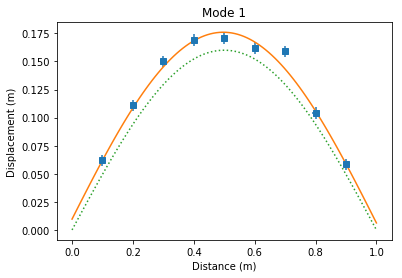

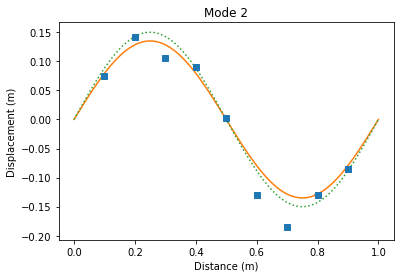

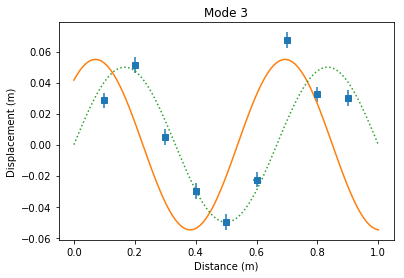

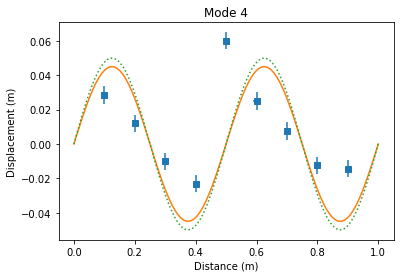

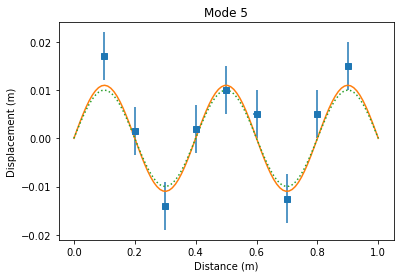

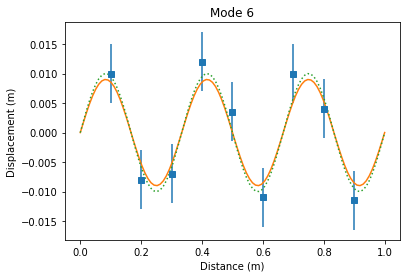

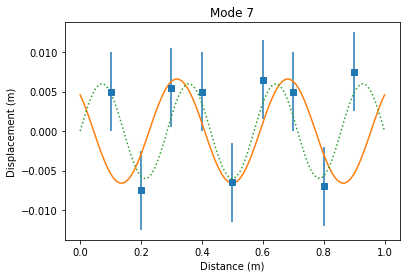

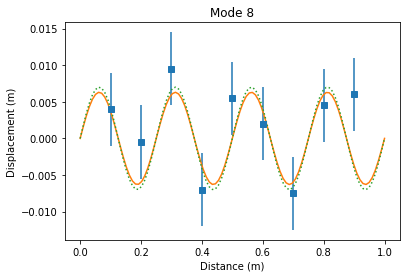

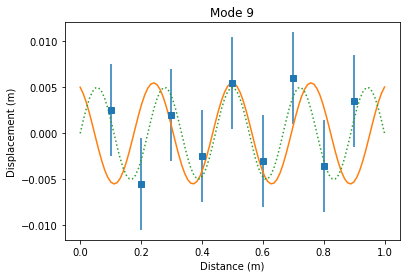

In [211]:
theo_lambdas = [(2*(9+1)*cardist)/m for m in range(1,10)]
sinusoid_amplitudes = np.array([16,15,5,5,1,1,0.6,0.7,0.5])/100
sinusoid_amplitudes2 = np.array([16,15,5,5,1,1,1,0.5,1])/100

exp_lambdas = []
exp_lambdas_unc = []

amplitude_measurement_uncertainty = 0.5e-2 # (1cm)
frequency_measurement_uncertainty = 0.01 # According to measurement equipment

for i in range(0,9): 
    plt.figure(i+1)
    plt.title("Mode "+str(i+1))
    plt.xlabel("Distance (m)")
    plt.ylabel("Displacement (m)")
    amps = np.array(pairs_amps(data["M"+str(i+1)]))/100
    amps_uncs = (amps**0)*amplitude_measurement_uncertainty
    xs_uncs = (xs**0)*frequency_measurement_uncertainty
    plt.errorbar(xs,amps, amps_uncs, xs_uncs, linestyle="None", marker="s")
    a, a_unc = bestfit(xs, amps,amps_uncs, xs_uncs)
    xx = np.linspace(0,1,100)
    
    # Plots sine curve based on chi square minimisation
    guesses = (sinusoid_amplitudes[i], (2*np.pi)/theo_lambdas[i], 0)
    #print("Guesses: ", guesses)

    params, calc_w_unc = calc_sin(guesses, np.column_stack((xs, amps)))
    #print("Params: ", params)
    exp_lambdas.append(params[1])
    exp_lambdas_unc.append(calc_w_unc)
    plt.plot(xx, sinusoid((guesses[0]*(0.9+((i+1)%2)*0.2), params[1], params[2]),xx))
    
    ## Plots sine curve according to theoretical standing wave
    plt.plot(xx, sinusoid((sinusoid_amplitudes[i],(2*np.pi)/theo_lambdas[i], 0), xx), linestyle=":")
    

w_to_lambda = lambda w: (2*np.pi)/w

###  Finding the Experimental Dispersion Relation

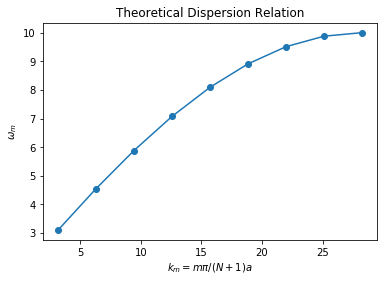

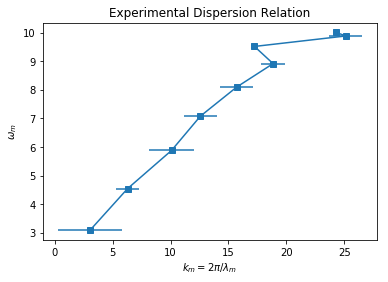

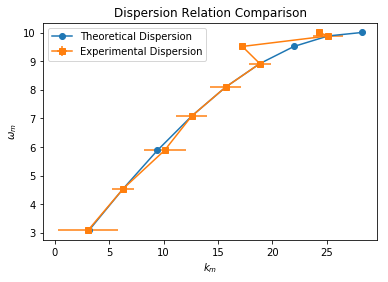

In [215]:
theo_k_m = [(m*np.pi)/(10*cardist) for m in range(1,10)]
ws = [w(i+1, s, m_car) for i in range(1,10)]
#print(theo_k_m)
plt.figure(1)
plt.plot(theo_k_m, ws, marker="o")
plt.title("Theoretical Dispersion Relation")
plt.xlabel("$k_m = m \pi / (N+1)a$")
plt.ylabel("$\omega_m$")



plt.figure(2)
plt.title("Experimental Dispersion Relation")
plt.xlabel("$k_m = 2 \pi / \lambda_m$")
plt.ylabel("$\omega_m$")
exp_k_m = [(2*np.pi)/l for l in exp_lambdas]
plt.errorbar(exp_lambdas, ws, 0, exp_lambdas_unc,marker ="s") #linestyle="none")

plt.figure(3)

plt.title("Dispersion Relation Comparison")
plt.xlabel("$k_m$")
plt.ylabel("$\omega_m$")

plt.plot(theo_k_m, ws, marker="o", label="Theoretical Dispersion")
plt.errorbar(exp_lambdas, ws, 0, exp_lambdas_unc,marker ="s", label="Experimental Dispersion") #linestyle="none")
plt.legend()

### Finding Phase and Group Velocity Experimentally

In [253]:
phase_vel = lambda w, k: w/k

# Propagation assuming uncertainty in angular freqs is minimal
phase_vel_unc = lambda v, k_unc, k: (v*k_unc)/k

sigfigs = [1,1,1,2,2,2,6,2,5]

print("Phase Velocity:")
print()
for i, val in enumerate(ws):
    phase_velocity = phase_vel(ws[i],exp_lambdas[i])
    phase_velocity_uncertainty = phase_vel_unc(phase_velocity, exp_lambdas_unc[i], exp_lambdas[i])
    #e = np.abs(Decimal(round_to_1(Decimal(phase_velocity_uncertainty)).as_tuple().exponent))
    #print(e)
    print("Phase Velocity for mode "+str(i+1)+":", round(Decimal(phase_velocity),sigfigs[i]),
          "+-",round_to_1(phase_velocity_uncertainty), "ms^-1")
    
## Sig figs need to match uncertainty

print()
print("Group Velocity:")
print()

## Group velocity code
## Average gradient of the 2 lines joining on either side?? Maybe ask someone

Phase Velocity:

Phase Velocity for mode 1: 1.0 +- 0.9 ms^-1
Phase Velocity for mode 2: 0.7 +- 0.1 ms^-1
Phase Velocity for mode 3: 0.6 +- 0.1 ms^-1
Phase Velocity for mode 4: 0.56 +- 0.06 ms^-1
Phase Velocity for mode 5: 0.52 +- 0.05 ms^-1
Phase Velocity for mode 6: 0.47 +- 0.03 ms^-1
Phase Velocity for mode 7: 0.551784 +- 9e-06 ms^-1
Phase Velocity for mode 8: 0.39 +- 0.02 ms^-1
Phase Velocity for mode 9: 0.41170 +- 5e-06 ms^-1

Group Velocity:



## Discussion

## Conclusion